### Import libraries to use

In [265]:
from PIL import Image
from skimage.feature import local_binary_pattern, hog, greycomatrix, greycoprops
from skimage.filters import gabor_kernel
from skimage import data
from scipy import ndimage, linalg
from tqdm import tqdm
from heapq import heappush, heappushpop
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

### Classes to extract features: LBP, HOG, Gabor, Haralick

In [150]:
class LocalBinaryPatterns:
    def __init__(self, P=8, R=2):
        self.P = P
        self.R = R
        self.bins = np.arange(0, 60) - 0.5
        self.bins[-1] = 255.5
    def describe(self, image, eps=1e-7):
        lbp = local_binary_pattern(image, self.P, self.R)
        (hist, _) = np.histogram(lbp.ravel(), bins=self.bins)
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

class HOG:
    def __init__(self, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1)):
        self.ori = orientations
        self.ppc = pixels_per_cell
        self.cpb = cells_per_block
    def describe(self, image):        
        return hog(image,
                   orientations=self.ori,
                   pixels_per_cell=self.ppc,
                   cells_per_block=self.cpb, multichannel=True)

class Gabor:
    def __init__(self, theta_range=8, sigmas=(1,3), frequencies=(0.05, 0.25)):
        kernels = []
        for theta in range(theta_range):
            theta = theta / 4. * np.pi
            for sigma in sigmas:
                for frequency in frequencies:
                    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                                  sigma_x=sigma, sigma_y=sigma))
                    kernels.append(kernel)
        self.kernels = kernels
    
    def describe(self, image):
        feats = np.zeros((len(self.kernels) * 2,), dtype=np.double)
        for k, kernel in enumerate(self.kernels):
            filtered = ndimage.convolve(image, kernel, mode='wrap')
            feats[2*k] = filtered.mean()
            feats[2*k+1] = filtered.var()
        return feats
    
class Haralick:
    def __init__(self, distances=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
        self.distances = distances
        self.angles = angles
        self.n = len(distances) * len(angles)
        self.props = ('contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation')
    def describe(self, image):
        glcm = greycomatrix(image, distances=self.distances, angles=self.angles,
                            levels=256, symmetric=True, normed=True)
        feats = np.empty((self.n * 6,), dtype=np.double)
        for i, prop in enumerate(self.props):
            feats[i * self.n : (i+1) * self.n] = greycoprops(glcm, prop).ravel()
        return feats

### Function to extract features for each image in a given folder

In [164]:
def extract_features(img_folder_path):
    _lbp = LocalBinaryPatterns()
    _hog = HOG()
    _gabor = Gabor()
    _haralick = Haralick()
    featmat = None
    img_paths = glob.glob(img_folder_path + '*.png')
    print(img_folder_path, ': %d images found' % len(img_paths))
    for i, imgpath in tqdm(enumerate(img_paths)):
        img = Image.open(imgpath)
        img_gray = img.convert('L')
        lbp_feat = _lbp.describe(img_gray)
        hog_feat = _hog.describe(img)
        gab_feat = _gabor.describe(img_gray)
        har_feat = _haralick.describe(np.asarray(img_gray).copy())
        feat_list = (lbp_feat, hog_feat, gab_feat, har_feat)
        feat_size = sum(len(x) for x in feat_list)
        if featmat is None:
            featmat = np.empty((len(img_paths), feat_size))
            print("featmat.shape = ", featmat.shape)
        offset = 0
        for feat in feat_list:
            featmat[i][offset:offset+len(feat)] = feat
            offset += len(feat)
    return featmat

### Extract and save features for Testing_0

In [165]:
feat_testing_0 = extract_features('./Testing_0/')

2it [00:00, 11.36it/s]

./Testing_0/ : 1000 images found
featmat.shape =  (1000, 323)


1000it [01:21, 12.23it/s]


In [171]:
np.save('feat_testing_0.npy', feat_testing_0)

### Extract and save features for Testing_1

In [172]:
feat_testing_1 = extract_features('./Testing_1/')

2it [00:00, 10.98it/s]

./Testing_1/ : 1000 images found
featmat.shape =  (1000, 323)


1000it [01:21, 12.21it/s]


In [173]:
np.save('feat_testing_1.npy', feat_testing_1)

### Extract and save features for Training_0

In [174]:
feat_training_0 = extract_features('./Training_0/')

2it [00:00, 11.13it/s]

./Training_0/ : 4000 images found
featmat.shape =  (4000, 323)


4000it [05:27, 12.22it/s]


In [175]:
np.save('feat_training_0.npy', feat_training_0)

### Extract and save features for Training_1

In [176]:
feat_training_1 = extract_features('./Training_1/')

2it [00:00, 11.84it/s]

./Training_1/ : 4000 images found
featmat.shape =  (4000, 323)


4000it [05:27, 12.23it/s]


In [177]:
np.save('feat_training_1.npy', feat_training_1)

### Load saved features

In [179]:
feat_train_0 = np.load('./feat_training_0.npy')
feat_train_1 = np.load('./feat_training_1.npy')
feat_test_0 = np.load('./feat_testing_0.npy')
feat_test_1 = np.load('./feat_testing_1.npy')

### Classifier that transforms and selects features with PCA and classifies with KNN

In [250]:
class PCA_KNN_Classifier:
    def __init__(self, feat_train_0, feat_train_1):
        
        # concatenate features
        train_feat = np.concatenate((feat_train_0, feat_train_1), axis=0)
        # mean
        self.feat_mean = train_feat.mean(0)
        # std
        self.feat_std = train_feat.std(0)
        # z-score normalization
        train_feat = (train_feat - self.feat_mean) / self.feat_std
        
        # PCA transformation
        cov = np.cov(train_feat, rowvar = False)
        evals , evecs = linalg.eigh(cov)
        idx = np.argsort(evals)[::-1]
        self.evecs = evecs[:,idx]
        self.evals = evals[idx]
        self.train_feat = np.dot(train_feat, self.evecs) 
        
        # train labels
        n = train_feat.shape[0]
        train_class = np.ones((n,), dtype=np.uint8)
        train_class[0:n//2] = 0
        self.train_class = train_class
        
    def classify(self, X, dist_func, pca_dim=20, k=3):
        # z-score normalize X
        X = (X - self.feat_mean) / self.feat_std
        # transform with PCA and select first 'pca_dim' features
        X = np.dot(X.reshape(1,-1), self.evecs).reshape(-1)[:pca_dim]
        # classify with KNN
        h = []
        for i in range(self.train_feat.shape[0]):
            t = (-dist_func(self.train_feat[i][:pca_dim], X), self.train_class[i])
            if len(h) < k:
                heappush(h, t)
            else:
                heappushpop(h, t)
        counts = [0, 0]
        for _, c in h:
            counts[c] += 1
        return 0 if counts[0] >= counts[1] else 1

### Init classifier

In [251]:
classifier = PCA_KNN_Classifier(feat_train_0, feat_train_1)

### Distance functions

In [258]:
def square_euclidean_distance(x, y):
    return ((x - y)**2).sum()

def cosine_distance(x, y):
    return -np.dot(x, y) / (linalg.norm(x) * linalg.norm(y))

### Function to calculate accuracy

In [259]:
def get_accuracy(classifier, feat_test_0, feat_test_1, dist_func, pca_dim, k):
    correct = 0
    for i in range(feat_test_0.shape[0]):
        correct += classifier.classify(feat_test_0[i], dist_func, pca_dim, k) == 0
    for i in range(feat_test_1.shape[0]):
        correct += classifier.classify(feat_test_1[i], dist_func, pca_dim, k) == 1
    return correct / (feat_test_0.shape[0] + feat_test_1.shape[0])

### Find best distance function and PCA dimension

In [261]:
for pca_dim in (2, 5, 10, 20, 35, 50):
    for dist_func, dist_name in zip((cosine_distance, square_euclidean_distance), ('cosine', 'euclidean')):
        print('---- pca_dim = %d, dist_name = %s ---' % (pca_dim, dist_name))
        print('\taccuracy =', get_accuracy(classifier, feat_test_0, feat_test_1, dist_func, pca_dim, 3))

---- pca_dim = 2, dist_name = cosine ---
	accuracy = 0.721
---- pca_dim = 2, dist_name = euclidean ---
	accuracy = 0.7865
---- pca_dim = 5, dist_name = cosine ---
	accuracy = 0.8645
---- pca_dim = 5, dist_name = euclidean ---
	accuracy = 0.906
---- pca_dim = 10, dist_name = cosine ---
	accuracy = 0.916
---- pca_dim = 10, dist_name = euclidean ---
	accuracy = 0.9415
---- pca_dim = 20, dist_name = cosine ---
	accuracy = 0.931
---- pca_dim = 20, dist_name = euclidean ---
	accuracy = 0.955
---- pca_dim = 35, dist_name = cosine ---
	accuracy = 0.933
---- pca_dim = 35, dist_name = euclidean ---
	accuracy = 0.9465
---- pca_dim = 50, dist_name = cosine ---
	accuracy = 0.923
---- pca_dim = 50, dist_name = euclidean ---
	accuracy = 0.9475


In [262]:
for pca_dim in (15, 18, 22, 25):
    print('---- pca_dim = %d, dist_name = euclidean ---' % pca_dim)
    print('\taccuracy =', get_accuracy(classifier, feat_test_0, feat_test_1, square_euclidean_distance, pca_dim, 3))

---- pca_dim = 15, dist_name = euclidean ---
	accuracy = 0.956
---- pca_dim = 18, dist_name = euclidean ---
	accuracy = 0.957
---- pca_dim = 22, dist_name = euclidean ---
	accuracy = 0.9545
---- pca_dim = 25, dist_name = euclidean ---
	accuracy = 0.955


In [263]:
for pca_dim in (19, 21):
    print('---- pca_dim = %d, dist_name = euclidean ---' % pca_dim)
    print('\taccuracy =', get_accuracy(classifier, feat_test_0, feat_test_1, square_euclidean_distance, pca_dim, 3))

---- pca_dim = 19, dist_name = euclidean ---
	accuracy = 0.9545
---- pca_dim = 21, dist_name = euclidean ---
	accuracy = 0.9545


### Function to plot confusion matrix

In [281]:
def plot_confusion_matrix(y_test, y_pred, figsize=(10,7)):
    n = 2
    matrix = np.zeros((n,n),dtype=np.int32)
    for a, b in zip(y_test, y_pred):
        matrix[a][b] += 1
    classes = ('LIMPIO', 'RAYADO')
    df_cm = pd.DataFrame(matrix, index = classes, columns = classes)
    plt.figure(figsize = figsize)
    sn.heatmap(df_cm, annot=True, fmt='g')

### Function to get list of individual class predictions

In [275]:
def get_predictions(classifier, feat_test_0, feat_test_1, dist_func, pca_dim, k):
    n0 = feat_test_0.shape[0]
    n1 = feat_test_1.shape[0]
    pred = [None] * (n0 + n1)
    for i in range(n0):
        pred[i] = classifier.classify(feat_test_0[i], dist_func, pca_dim, k)
    for i in range(n1):
        pred[n0 + i] = classifier.classify(feat_test_1[i], dist_func, pca_dim, k)
    return pred

### Get predictions, accuracy and confusion matrix for best version

In [276]:
best_pred = get_predictions(classifier, feat_test_0, feat_test_1, square_euclidean_distance, 18, 3)

In [277]:
test_labels = [0] * feat_test_0.shape[0] + [1] * feat_test_1.shape[0]

In [279]:
sum(x == y for x, y in zip(best_pred, test_labels)) / len(test_labels)

0.957

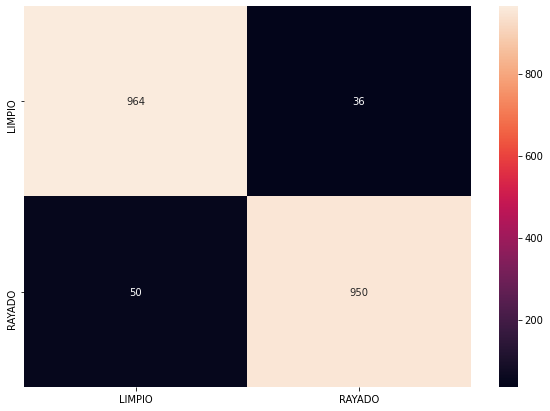

In [282]:
plot_confusion_matrix(test_labels, best_pred)